In [1]:
import faiss
import numpy as np
import json
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [6]:
FAISS_INDEX_PATH = "output/faiss_index.bin"
EMBEDDINGS_JSON = "output/embeddings.json"

In [7]:
print("🔍 Loading FAISS Index...")
index = faiss.read_index(FAISS_INDEX_PATH)


🔍 Loading FAISS Index...


In [8]:
with open(EMBEDDINGS_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

In [9]:
texts = data["texts"]
embeddings = np.array(data["embeddings"], dtype=np.float32)

In [10]:
print(f"✅ FAISS index contains {index.ntotal} stored vectors.")

✅ FAISS index contains 39 stored vectors.


In [11]:
embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")


In [19]:
def search_faiss(query, top_k=5):
    """
    Performs a FAISS similarity search for a given query and returns retrieved document texts.
    """
    query_embedding = embedder.encode(query, convert_to_tensor=False).astype("float32")
    
    distances, indices = index.search(np.array([query_embedding]), top_k)

    print(f"\n🔹 Query: {query}")
    print("🔍 Top Matching Documents:\n")

    retrieved_docs = []
    for i, idx in enumerate(indices[0]):
        if idx < len(texts):  # Ensure index is within bounds
            doc_text = texts[idx].strip()
            retrieved_docs.append((doc_text, distances[0][i]))
            print(f"{i+1}. {doc_text} (Score: {distances[0][i]:.4f})")

    return retrieved_docs, indices[0], distances[0]

# 📌 Run an example query to test
query = "Find the order id."
retrieved_docs, top_indices, _ = search_faiss(query, top_k=3)



🔹 Query: Find the order id.
🔍 Top Matching Documents:

1. Order ID: 10248 (Score: 0.6732)
2. Order Date: 2016-07-04 (Score: 0.8814)
3. Product ID (Score: 0.9493)


In [18]:
query = "Find the unit price and product name"
search_faiss(query, top_k=3)


🔹 Query: Find the unit price and product name
🔍 Top Matching Documents:

1. Unit Price (Score: 0.7310)
2. Product Name (Score: 0.8392)
3. Product ID (Score: 0.9696)


([('Unit Price', 0.7310325),
  ('Product Name', 0.83920574),
  ('Product ID', 0.9695886)],
 array([23, 21, 20], dtype=int64),
 array([0.7310325 , 0.83920574, 0.9695886 ], dtype=float32))

In [14]:
def plot_similarity_matrix(query_embedding, top_indices):
    """
    Visualizes cosine similarity between the query embedding and retrieved vectors.
    """
    retrieved_vectors = embeddings[top_indices]
    
    similarity_scores = np.dot(retrieved_vectors, query_embedding) / (
        np.linalg.norm(retrieved_vectors, axis=1) * np.linalg.norm(query_embedding)
    )

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(top_indices)), similarity_scores[::-1], color="blue")
    plt.yticks(range(len(top_indices)), [texts[i] for i in top_indices[::-1]], fontsize=10)
    plt.xlabel("Cosine Similarity", fontsize=12)
    plt.title("Similarity Scores for Top Retrieved Documents", fontsize=14)
    plt.show()


🔹 Query: Find the unit price and product name
🔍 Top Matching Documents:

1. Unit Price (Score: 0.7310)
2. Product Name (Score: 0.8392)
3. Product ID (Score: 0.9696)
4. Product Details: (Score: 1.0672)
5. TotalPrice (Score: 1.1497)


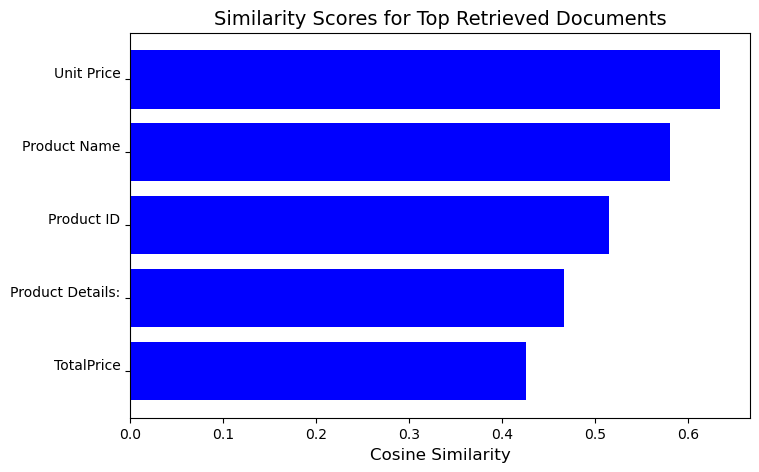

In [15]:
query_embedding = embedder.encode(query, convert_to_tensor=False).astype("float32")
top_indices, _ = search_faiss(query, top_k=5)
plot_similarity_matrix(query_embedding, top_indices)